<a href="https://colab.research.google.com/github/Ravikiran-Bhonagiri/AI-Agents/blob/main/Noise_Feats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install librosa pywavelets noisereduce scipy

In [ ]:
import pandas as pd

import librosa
import numpy as np
import pywt
import noisereduce as nr
from scipy.signal import welch

In [ ]:
import librosa
import numpy as np
import pandas as pd
from scipy.signal import hilbert
from scipy.stats import skew, kurtosis

def extract_audio_features(audio_file):
    """
    Extract audio features from the input audio file.

    Parameters:
        audio_file (str): Path to the audio file.

    Returns:
        dict: Dictionary of extracted audio features.
    """
    # Load the audio file
    y, sr = librosa.load(audio_file, sr=None)

    # Feature extraction
    features = {}

    # 1. Zero Crossing Rate (ZCR)
    features["zcr_mean"] = np.mean(librosa.feature.zero_crossing_rate(y))

    # 2. Spectral Centroid
    features["spectral_centroid_mean"] = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))

    # 3. Spectral Rolloff
    features["spectral_rolloff_mean"] = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))

    # 4. Spectral Bandwidth
    features["spectral_bandwidth_mean"] = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))

    # 5. Root Mean Square (RMS) Energy
    features["rms_mean"] = np.mean(librosa.feature.rms(y=y))

    # 6. Mel-Frequency Cepstral Coefficients (MFCCs)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    for i in range(13):
        features[f"mfcc_{i+1}_mean"] = np.mean(mfccs[i])

    # 7. Chroma Features (STFT)
    features["chroma_mean"] = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))

    # 8. Spectral Contrast
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    features["spectral_contrast_mean"] = np.mean(spectral_contrast)

    # 9. Tonnetz (Tonal Centroid Features)
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
    features["tonnetz_mean"] = np.mean(tonnetz)

    # 10. Onset Strength
    onset_strength = librosa.onset.onset_strength(y=y, sr=sr)
    features["onset_strength_mean"] = np.mean(onset_strength)

    # 11. Harmonic and Percussive RMS
    harmonic, percussive = librosa.effects.hpss(y)
    features["harmonic_rms"] = np.mean(librosa.feature.rms(y=harmonic))
    features["percussive_rms"] = np.mean(librosa.feature.rms(y=percussive))

    # 12. Pitch (Fundamental Frequency)
    f0, _, _ = librosa.pyin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    features["mean_pitch"] = np.nanmean(f0) if np.nanmean(f0) is not np.nan else 0

    # 13. Tempo (BPM)
    tempo = librosa.feature.rhythm.tempo(y=y, sr=sr)[0]  # Updated for newer versions of librosa
    features["tempo"] = tempo

    # 14. Chromagram from Constant-Q Transform (CQT)
    chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr)
    features["chroma_cqt_mean"] = np.mean(chroma_cqt)

    # 15. Spectral Flatness
    features["spectral_flatness_mean"] = np.mean(librosa.feature.spectral_flatness(y=y))

    # 16. Spectral Entropy
    def spectral_entropy(audio_signal, num_bins=10):
        power_spectrum = np.abs(np.fft.fft(audio_signal)) ** 2
        histogram, _ = np.histogram(power_spectrum, bins=num_bins, density=True)
        entropy = -np.sum(histogram * np.log2(histogram + 1e-10))
        return entropy

    features["spectral_entropy"] = spectral_entropy(y)

    # 17. Crest Factor
    features["crest_factor"] = np.max(np.abs(y)) / features["rms_mean"]

    # 18. Attack Time and Decay Time
    def envelope_slope(y, sr):
        analytic_signal = hilbert(y)
        amplitude_envelope = np.abs(analytic_signal)
        attack = np.argmax(amplitude_envelope > 0.5 * np.max(amplitude_envelope)) / sr
        decay = (len(y) - np.argmax(amplitude_envelope[::-1] > 0.5 * np.max(amplitude_envelope))) / sr
        return attack, decay

    attack_time, decay_time = envelope_slope(y, sr)
    features["attack_time"] = attack_time
    features["decay_time"] = decay_time

    # 19. Skewness and Kurtosis
    features["skewness"] = skew(y)
    features["kurtosis"] = kurtosis(y)

    return features

In [ ]:
import librosa
import numpy as np
import pywt
import noisereduce as nr
from scipy.signal import welch

def extract_industrial_noise_features(file_path, sr=22050):
    """Extract all audio features for industrial noise detection"""
    # Load and preprocess audio
    y, sr = librosa.load(file_path, sr=sr)
    y = librosa.effects.trim(y, top_db=20)[0]  # Trim silence
    y = nr.reduce_noise(y=y, sr=sr)  # Optional noise reduction

    # Initialize feature dictionary
    features = {}

    # ================== TIME DOMAIN FEATURES ==================
    features['zcr_mean'] = np.mean(librosa.feature.zero_crossing_rate(y))
    features['rms_mean'] = np.mean(librosa.feature.rms(y=y))
    features['temp_entropy'] = np.mean(librosa.feature.spectral_flatness(y=y))

    # ================== FREQUENCY DOMAIN FEATURES ==================
    S = np.abs(librosa.stft(y))

    # Spectral features
    features['spectral_centroid'] = np.mean(librosa.feature.spectral_centroid(S=S))
    features['spectral_bandwidth'] = np.mean(librosa.feature.spectral_bandwidth(S=S))
    features['spectral_rolloff'] = np.mean(librosa.feature.spectral_rolloff(S=S))
    features['spectral_contrast'] = np.mean(librosa.feature.spectral_contrast(S=S))
    features['spectral_flatness'] = np.mean(librosa.feature.spectral_flatness(S=S))
    #features['spectral_kurtosis'] = np.mean(librosa.feature.spectral_kurtosis(S=S))
    features['spectral_flux'] = np.mean(librosa.onset.onset_strength(S=librosa.util.normalize(S)))

    # ================== TIME-FREQUENCY FEATURES ==================
    # Wavelet transform
    coeffs, _ = pywt.dwt(y, 'db4')
    features['wavelet_energy'] = np.sum(coeffs**2)

    # Mel features
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64)
    features['mel_mean'] = np.mean(mel)
    features['mel_std'] = np.std(mel)

    # MFCCs with deltas
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    features['mfccs_mean'] = np.mean(mfccs, axis=1)
    features['mfccs_std'] = np.std(mfccs, axis=1)
    features['mfcc_delta'] = np.mean(librosa.feature.delta(mfccs))
    features['mfcc_delta2'] = np.mean(librosa.feature.delta(mfccs, order=2))

    # ================== ADVANCED FEATURES ==================
    # Harmonic-percussive separation
    y_harm, y_perc = librosa.effects.hpss(y)
    features['harmonic_ratio'] = np.mean(y_harm**2) / (np.mean(y_perc**2) + 1e-6)

    # Chroma features
    chroma = librosa.feature.chroma_stft(S=S, sr=sr)
    features['chroma_mean'] = np.mean(chroma)

    # Tempogram (rhythm analysis)
    tempogram = librosa.feature.tempogram(y=y, sr=sr)
    features['tempogram_mean'] = np.mean(tempogram)


    # ================== STATISTICAL FEATURES ==================
    from scipy.stats import skew, kurtosis
    features["skewness"] = skew(y)
    features["kurtosis"] = kurtosis(y)

    # ================== POWER ANALYSIS ==================
    freqs, psd = welch(y, sr)
    features['psd_peak_freq'] = freqs[np.argmax(psd)]
    features['psd_total'] = np.sum(psd)


    return features

| **Category**          | **Key Features**                                      | **Industrial Use Case**                     |
|------------------------|-------------------------------------------------------|---------------------------------------------|
| **Time-Domain**        | ZCR, RMS, Autocorrelation                             | Impact detection, periodic faults          |
| **Frequency-Domain**   | Spectral Centroid, Flux, Kurtosis                     | Bearing faults, high-frequency leaks       |
| **Time-Frequency**     | Wavelet Energy, MFCCs, Chroma                         | Transient clicks, harmonic distortions     |
| **Advanced**           | Percussive Energy, Cepstrum, PSD                      | Valve knocks, gear defects                 |
| **Statistical**        | Skewness, Kurtosis of RMS/ZCR                         | Non-Gaussian anomaly detection             |


In [ ]:
import librosa
import numpy as np
import pywt
import noisereduce as nr
from scipy.signal import welch

def extract_industrial_features_advanced(file_path, sr=22050):
    """Extract all industrial noise/anomaly features"""
    # Preprocess
    y, sr = librosa.load(file_path, sr=sr)
    y = librosa.effects.trim(y, top_db=20)[0]
    y = nr.reduce_noise(y=y, sr=sr)  # Optional

    features = {}

    # ================== Time Domain ==================
    features["zcr_mean"] = np.mean(librosa.feature.zero_crossing_rate(y))
    features["rms_mean"] = np.mean(librosa.feature.rms(y=y))
    features["temp_entropy"] = np.mean(librosa.feature.spectral_flatness(y=y))

    # Autocorrelation
    autocorr = np.correlate(y, y, mode='full')
    features["autocorr_peak"] = np.max(autocorr[len(autocorr)//2:])

    # ================== Frequency Domain ==================
    S = np.abs(librosa.stft(y))

    # Spectral features
    features['spectral_centroid'] = np.mean(librosa.feature.spectral_centroid(S=S))
    features['spectral_bandwidth'] = np.mean(librosa.feature.spectral_bandwidth(S=S))
    features['spectral_rolloff'] = np.mean(librosa.feature.spectral_rolloff(S=S))
    features['spectral_contrast'] = np.mean(librosa.feature.spectral_contrast(S=S))
    features['spectral_flatness'] = np.mean(librosa.feature.spectral_flatness(S=S))
    #features['spectral_kurtosis'] = np.mean(librosa.feature.spectral_kurtosis(S=S))
    features['spectral_flux'] = np.mean(librosa.onset.onset_strength(S=librosa.util.normalize(S)))

    # ================== Time-Frequency ==================
    # Wavelet transform
    coeffs, _ = pywt.dwt(y, 'db4')
    features["wavelet_energy"] = np.sum(coeffs**2)

    # MFCCs with deltas
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    features.update({
        f"mfcc_{i}_mean": np.mean(mfccs[i]) for i in range(13)
    })
    features.update({
        f"mfcc_{i}_std": np.std(mfccs[i]) for i in range(13)
    })

    # Chroma
    chroma = librosa.feature.chroma_stft(S=S, sr=sr)
    features["chroma_mean"] = np.mean(chroma)

    # ================== Advanced Features ==================
    # Harmonic-percussive separation
    y_harm, y_perc = librosa.effects.hpss(y)
    features["percussive_energy"] = np.mean(y_perc**2)


    # Power Spectral Density
    freqs, psd = welch(y, sr)
    features["psd_peak_freq"] = freqs[np.argmax(psd)]
    features["psd_total"] = np.sum(psd)

    # ================== Statistical Features ==================

    # Spectral Flatness
    spectral_flatness = librosa.feature.spectral_flatness(y=y)
    features['flatness_mean'] = np.mean(spectral_flatness)

    # Amplitude Modulation Spectrum
    S_envelope = np.abs(librosa.stft(y)).mean(axis=0)
    modulation_spectrum = np.abs(np.fft.fft(S_envelope))
    features['modulation_peak'] = np.max(modulation_spectrum)

    from scipy.stats import skew, kurtosis
    features["skewness"] = skew(y)
    features["kurtosis"] = kurtosis(y)

    return features

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

directory_path = "/content/drive/MyDrive/almIT_Anamoly_Audios"

# List all .wav files
if os.path.exists(directory_path):
    wav_files = [f"{directory_path}/{f}" for f in os.listdir(directory_path) if f.endswith('.wav')]
    print("Found .wav files:", wav_files)
else:
    print(f"Directory not found: {directory_path}")

Found .wav files: ['/content/drive/MyDrive/almIT_Anamoly_Audios/OnState1.wav', '/content/drive/MyDrive/almIT_Anamoly_Audios/OffState1.wav', '/content/drive/MyDrive/almIT_Anamoly_Audios/Normal1.wav', '/content/drive/MyDrive/almIT_Anamoly_Audios/OnState2.wav', '/content/drive/MyDrive/almIT_Anamoly_Audios/OffState2.wav', '/content/drive/MyDrive/almIT_Anamoly_Audios/Normal2.wav', '/content/drive/MyDrive/almIT_Anamoly_Audios/OnState3.wav', '/content/drive/MyDrive/almIT_Anamoly_Audios/Normal3.wav', '/content/drive/MyDrive/almIT_Anamoly_Audios/OffState3.wav', '/content/drive/MyDrive/almIT_Anamoly_Audios/OnState4.wav', '/content/drive/MyDrive/almIT_Anamoly_Audios/Normal4.wav', '/content/drive/MyDrive/almIT_Anamoly_Audios/OffState4.wav', '/content/drive/MyDrive/almIT_Anamoly_Audios/OnState5.wav', '/content/drive/MyDrive/almIT_Anamoly_Audios/Normal5.wav', '/content/drive/MyDrive/almIT_Anamoly_Audios/OffState5.wav', '/content/drive/MyDrive/almIT_Anamoly_Audios/OnState6.wav', '/content/drive/MyDri

In [ ]:
def map_filename_to_case(filepath):
    """
    Maps industrial audio files to categorical cases based on filename patterns.
    Returns: (str) case identifier
    """
    filename = filepath.split("/")[-1].lower()  # Get filename without path

    # Define pattern mappings
    case_mapping = [
        ("onstate", "on_state"),
        ("offstate", "off_state"),
        ("normal", "normal_state"),
        ("paper", "paper_sound"),
        ("solidsound", "solid_sound"),
        ("boltsound", "bolt_sound")
    ]

    # Check for matching patterns
    for pattern, value in case_mapping:
        if pattern in filename:
            return value

    return "unknown"  # Fallback for unexpected files

In [ ]:
wav_files = wav_files[:-2]

In [ ]:
wav_files

['/content/drive/MyDrive/almIT_Anamoly_Audios/OnState1.wav',
 '/content/drive/MyDrive/almIT_Anamoly_Audios/OffState1.wav',
 '/content/drive/MyDrive/almIT_Anamoly_Audios/Normal1.wav',
 '/content/drive/MyDrive/almIT_Anamoly_Audios/OnState2.wav',
 '/content/drive/MyDrive/almIT_Anamoly_Audios/OffState2.wav',
 '/content/drive/MyDrive/almIT_Anamoly_Audios/Normal2.wav',
 '/content/drive/MyDrive/almIT_Anamoly_Audios/OnState3.wav',
 '/content/drive/MyDrive/almIT_Anamoly_Audios/Normal3.wav',
 '/content/drive/MyDrive/almIT_Anamoly_Audios/OffState3.wav',
 '/content/drive/MyDrive/almIT_Anamoly_Audios/OnState4.wav',
 '/content/drive/MyDrive/almIT_Anamoly_Audios/Normal4.wav',
 '/content/drive/MyDrive/almIT_Anamoly_Audios/OffState4.wav',
 '/content/drive/MyDrive/almIT_Anamoly_Audios/OnState5.wav',
 '/content/drive/MyDrive/almIT_Anamoly_Audios/Normal5.wav',
 '/content/drive/MyDrive/almIT_Anamoly_Audios/OffState5.wav',
 '/content/drive/MyDrive/almIT_Anamoly_Audios/OnState6.wav',
 '/content/drive/MyDrive

In [ ]:
final_audio_features = []

for audio_file in wav_files:
    audio_features = extract_industrial_noise_features(audio_file)
    audio_features["audio_label"] = map_filename_to_case(audio_file)
    final_audio_features.append(audio_features)
    print(f"Extracted features from {audio_file}")

# Optionally, save features to CSV
df_features = pd.DataFrame(final_audio_features)
df_features.to_csv("/content/audio_features_version_1.csv", index=False)

Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/OnState1.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/OffState1.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/Normal1.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/OnState2.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/OffState2.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/Normal2.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/OnState3.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/Normal3.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/OffState3.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/OnState4.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/Normal4.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/OffState4.wav
Extracted features from /con

In [ ]:
final_audio_features = []

for audio_file in wav_files:
    audio_features = extract_industrial_features_advanced(audio_file)
    audio_features["audio_label"] = map_filename_to_case(audio_file)
    final_audio_features.append(audio_features)
    print(f"Extracted features from {audio_file}")

# Optionally, save features to CSV
df_features = pd.DataFrame(final_audio_features)
df_features.to_csv("/content/audio_features_version_2.csv", index=False)

Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/OnState1.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/OffState1.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/Normal1.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/OnState2.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/OffState2.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/Normal2.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/OnState3.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/Normal3.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/OffState3.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/OnState4.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/Normal4.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/OffState4.wav
Extracted features from /con

In [ ]:
final_audio_features = []

for audio_file in wav_files:
    audio_features = extract_audio_features(audio_file)
    audio_features["audio_label"] = map_filename_to_case(audio_file)
    final_audio_features.append(audio_features)
    print(f"Extracted features from {audio_file}")

# Optionally, save features to CSV
df_features = pd.DataFrame(final_audio_features)
df_features.to_csv("/content/audio_features_basic.csv", index=False)

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=762
  warnings.warn(


Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/OnState1.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/OffState1.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/Normal1.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/OnState2.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/OffState2.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/Normal2.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/OnState3.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/Normal3.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/OffState3.wav


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=1009
  warnings.warn(


Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/OnState4.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/Normal4.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/OffState4.wav


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=971
  warnings.warn(


Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/OnState5.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/Normal5.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/OffState5.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/OnState6.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/Normal6.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/OffState6.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/OnState7.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/Normal7.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/OffState7.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/OnState8.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/Normal8.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/OffState8.wav
Extracted features from /con

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=952
  warnings.warn(


Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/OnState9.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/OnState10.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/Normal10.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/OffState10.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/OnState11.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/Normal11.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/OffState.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/OffState11.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/Paper1.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/Paper2.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/Paper3.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/Paper4.wav
Extracted features from /conte

<ipython-input-77-c2b5471f1c97>:65: RuntimeWarning: Mean of empty slice
  features["mean_pitch"] = np.nanmean(f0) if np.nanmean(f0) is not np.nan else 0


Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/solidsound8.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/solidsound9.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/solidsound10.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/solidsound11.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/solidsound12.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/solidsound14.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/solidsound15.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/boltsound11.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/boltsound12.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/boltsound13.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/boltsound14.wav
Extracted features from /content/drive/MyDrive/almIT_Anamoly_Audios/bol

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt

def fill_missing_and_plot_pca(df, n_components=2):
    """
    Fill missing values, perform PCA, and plot.

    Parameters:
        df (DataFrame): Input dataframe with features and 'audio_label'
        n_components (int): Number of PCA components
    """
    # Clean data: Convert string arrays to numeric
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

    # If features are stored as strings (e.g., "[1.2 3.4]")
    if 'features' in df.columns and df['features'].dtype == object:
        df[numeric_cols] = df['features'].apply(
            lambda x: np.fromstring(x.strip('[]'), sep=' ')
        ).tolist()

    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

    # Normalize
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[numeric_cols])

    # PCA
    pca = PCA(n_components=n_components)
    pca_features = pca.fit_transform(scaled_data)

    # Plot
    df['pca_1'] = pca_features[:, 0]
    df['pca_2'] = pca_features[:, 1]

    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x='pca_1', y='pca_2',
        hue='audio_label',
        data=df, palette='Set2', s=100
    )
    plt.title(f'PCA ({pca.explained_variance_ratio_.sum():.1%} variance explained)')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    plt.legend(title='Label', bbox_to_anchor=(1.05, 1))
    plt.show()

In [ ]:
df1 = pd.read_csv("/content/audio_features_version_1.csv")
df2 = pd.read_csv("/content/audio_features_version_2.csv")
df3 = pd.read_csv("/content/audio_features_basic.csv")

In [ ]:
df1.head()

,zcr_mean,rms_mean,temp_entropy,spectral_centroid,spectral_bandwidth,spectral_rolloff,spectral_contrast,spectral_flatness,spectral_flux,wavelet_energy,...,mfcc_delta,mfcc_delta2,harmonic_ratio,chroma_mean,tempogram_mean,skewness,kurtosis,psd_peak_freq,psd_total,audio_label
0,0.022867,0.112218,0.027144,658.283579,1034.184551,1453.351385,19.101719,0.027144,0.003768,1042.29210,...,0.362885,-0.037764,0.918396,0.632457,0.115420,-0.174262,4.290328,258.398438,0.000275,on_state
1,0.023475,0.039788,0.293769,459.478027,678.309920,926.243239,14.251053,0.293769,0.002543,1207.98610,...,-0.170904,-0.009276,1.617549,0.711427,0.076285,-0.199976,11.917119,344.531250,0.000088,off_state
2,0.105711,0.007822,0.002627,1732.729751,2130.745094,3590.624622,25.913121,0.002627,0.007888,64.05065,...,-0.018347,-0.005595,0.423708,0.602198,0.237433,-0.616656,28.809088,172.265625,0.000002,normal_state
3,0.058372,0.089374,0.035610,1307.062697,1447.080769,2513.413373,19.235875,0.035610,0.004540,705.27563,...,0.455907,-0.010630,1.555227,0.613340,0.148877,-0.189518,0.733802,344.531250,0.000123,on_state
4,0.012265,0.045463,0.225552,323.560949,498.213482,681.359566,16.172043,0.225552,0.002201,1423.04960,...,-0.163748,-0.001313,1.770907,0.739621,0.102970,-0.385932,14.529463,344.531250,0.000120,off_state


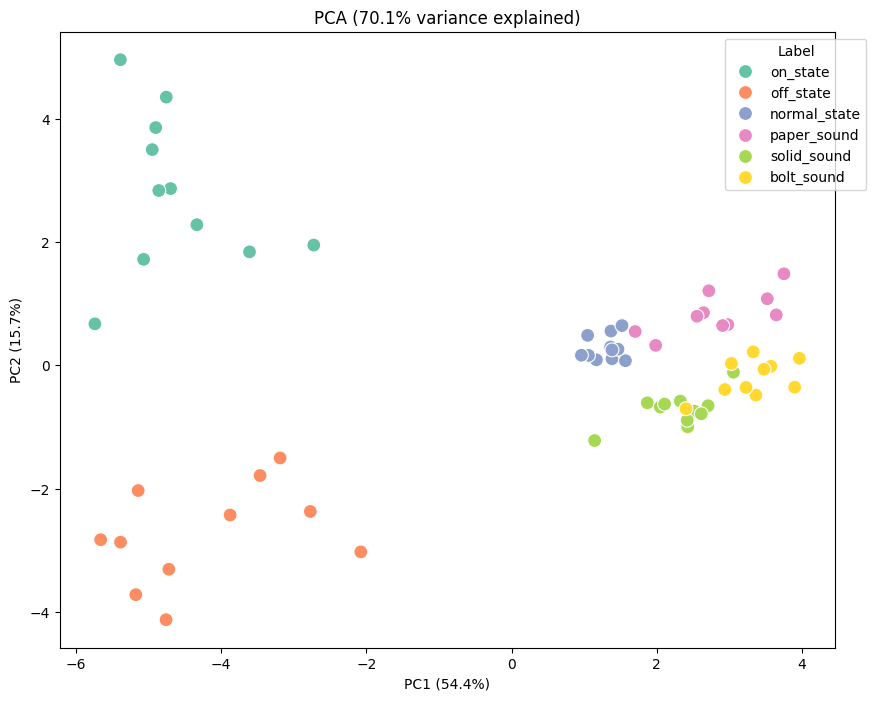

In [ ]:
# Perform PCA and plot
fill_missing_and_plot_pca(df1, n_components=2)

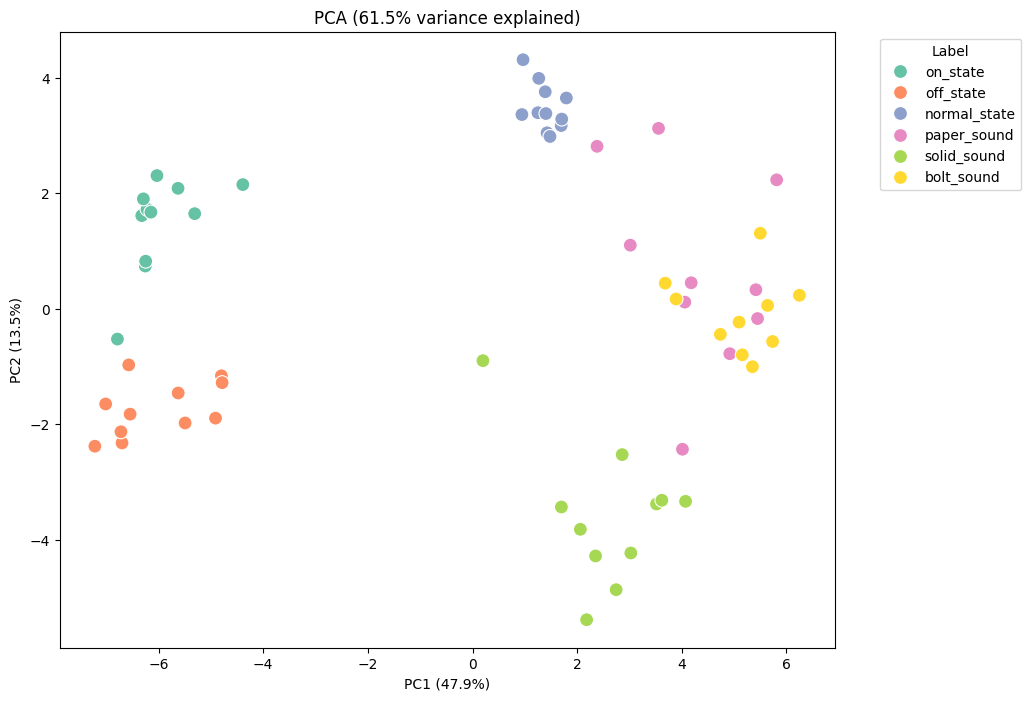

In [ ]:
# Perform PCA and plot
fill_missing_and_plot_pca(df2, n_components=2)

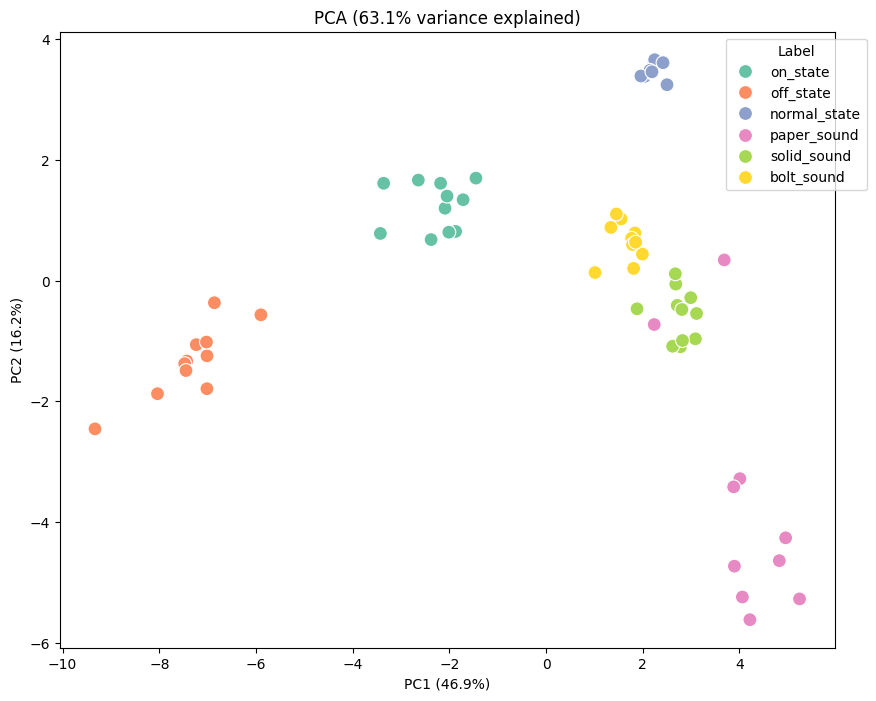

In [ ]:
# Perform PCA and plot
fill_missing_and_plot_pca(df3, n_components=2)

In [ ]:
df1.head()

,zcr_mean,rms_mean,temp_entropy,spectral_centroid,spectral_bandwidth,spectral_rolloff,spectral_contrast,spectral_flatness,spectral_flux,wavelet_energy,...,mfcc_delta,mfcc_delta2,harmonic_ratio,chroma_mean,tempogram_mean,skewness,kurtosis,psd_peak_freq,psd_total,audio_label
0,0.022867,0.112218,0.027144,658.283579,1034.184551,1453.351385,19.101719,0.027144,0.003768,1042.29210,...,0.362885,-0.037764,0.918396,0.632457,0.115420,-0.174262,4.290328,258.398438,0.000275,on_state
1,0.023475,0.039788,0.293769,459.478027,678.309920,926.243239,14.251053,0.293769,0.002543,1207.98610,...,-0.170904,-0.009276,1.617549,0.711427,0.076285,-0.199976,11.917119,344.531250,0.000088,off_state
2,0.105711,0.007822,0.002627,1732.729751,2130.745094,3590.624622,25.913121,0.002627,0.007888,64.05065,...,-0.018347,-0.005595,0.423708,0.602198,0.237433,-0.616656,28.809088,172.265625,0.000002,normal_state
3,0.058372,0.089374,0.035610,1307.062697,1447.080769,2513.413373,19.235875,0.035610,0.004540,705.27563,...,0.455907,-0.010630,1.555227,0.613340,0.148877,-0.189518,0.733802,344.531250,0.000123,on_state
4,0.012265,0.045463,0.225552,323.560949,498.213482,681.359566,16.172043,0.225552,0.002201,1423.04960,...,-0.163748,-0.001313,1.770907,0.739621,0.102970,-0.385932,14.529463,344.531250,0.000120,off_state


In [ ]:
df2.head()

,zcr_mean,rms_mean,temp_entropy,autocorr_peak,spectral_centroid,spectral_bandwidth,spectral_rolloff,spectral_contrast,spectral_flatness,spectral_flux,...,mfcc_12_std,chroma_mean,percussive_energy,psd_peak_freq,psd_total,flatness_mean,modulation_peak,skewness,kurtosis,audio_label
0,0.022867,0.112218,0.027144,1043.19370,658.283579,1034.184551,1453.351385,19.101719,0.027144,0.003768,...,6.606514,0.632457,0.007967,258.398438,0.000275,0.027144,60.419200,-0.174262,4.290328,on_state
1,0.023475,0.039788,0.293769,1210.44900,459.478027,678.309920,926.243239,14.251053,0.293769,0.002543,...,4.481436,0.711427,0.001976,344.531250,0.000088,0.293769,87.471075,-0.199976,11.917119,off_state
2,0.105711,0.007822,0.002627,64.12622,1732.729751,2130.745094,3590.624622,25.913121,0.002627,0.007888,...,16.390055,0.602198,0.000099,172.265625,0.000002,0.002627,29.991689,-0.616656,28.809088,normal_state
3,0.058372,0.089374,0.035610,706.46010,1307.062697,1447.080769,2513.413373,19.235875,0.035610,0.004540,...,7.332656,0.613340,0.002750,344.531250,0.000123,0.035610,81.221981,-0.189518,0.733802,on_state
4,0.012265,0.045463,0.225552,1425.37550,323.560949,498.213482,681.359566,16.172043,0.225552,0.002201,...,6.267956,0.739621,0.002584,344.531250,0.000120,0.225552,84.285656,-0.385932,14.529463,off_state


In [ ]:
df3.head()

,zcr_mean,spectral_centroid_mean,spectral_rolloff_mean,spectral_bandwidth_mean,rms_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,...,spectral_flatness_mean,spectral_entropy,crest_factor,attack_time,decay_time,skewness,kurtosis,audio_label,pca_1,pca_2
0,0.009150,896.359779,1302.927898,2169.728505,0.231079,-258.905100,167.60843,26.625720,49.342327,26.822054,...,0.000127,3.949852e-05,4.327522,0.000000,2.209070,-0.038072,2.326848,on_state,-3.359729,1.612208
1,0.004183,756.287492,669.625006,2456.603626,0.060211,-406.969760,104.80351,60.138638,37.642982,19.650630,...,0.000070,9.513910e-06,16.608200,0.002381,1.312313,-0.234523,31.964301,off_state,-9.330551,-2.458442
2,0.018197,1405.938307,3108.513964,2580.830116,0.561389,-60.415672,182.03734,-8.825540,67.857000,3.107997,...,0.000335,2.634271e-07,1.781295,0.000000,13.502902,-0.065244,-0.972823,normal_state,2.501279,3.245165
3,0.012423,1116.605770,2008.592925,2417.722096,0.305903,-222.687120,156.27261,23.737860,53.479115,18.953892,...,0.000441,7.391524e-06,3.269011,2.043197,4.111859,-0.118270,0.950120,on_state,-1.871165,0.814251
4,0.005430,699.778828,686.334813,2200.296853,0.112564,-364.247200,113.19740,52.720230,43.412570,27.194012,...,0.000061,1.187746e-05,8.883812,0.002721,1.249048,-0.225377,11.270143,off_state,-7.433297,-1.333617


In [104]:
import warnings
warnings.filterwarnings("ignore")

In [121]:
import joblib
import os
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Perceptron
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Lookup function for classifiers
algorithm_names = [
    'Random Forest', 'SVM', 'KNN', 'Logistic Regression', 'XGBoost', 'Decision Tree', 'Naive Bayes',
    'Gradient Boosting', 'AdaBoost', 'Extra Trees', 'Bagging',
    'LDA', 'QDA', 'Ridge Classifier']

# Function to get the classifier based on the name
def get_classifier(algorithm_name):
    classifiers = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'SVM': SVC(kernel='linear', probability=True, random_state=42),
        'KNN': KNeighborsClassifier(n_neighbors=5),
        'Logistic Regression': LogisticRegression(solver='lbfgs', max_iter=500, random_state=42),
        'XGBoost': XGBClassifier(objective='multi:softmax', eval_metric='mlogloss', random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Naive Bayes': GaussianNB(),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'AdaBoost': AdaBoostClassifier(random_state=42),
        'Extra Trees': ExtraTreesClassifier(random_state=42),
        'Bagging': BaggingClassifier(random_state=42),
        'LDA': LinearDiscriminantAnalysis(),
        'QDA': QuadraticDiscriminantAnalysis(),
        'Ridge Classifier': RidgeClassifier(random_state=42)
    }
    return classifiers.get(algorithm_name)


In [122]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


df = pd.read_csv("/content/audio_features_basic.csv")

# Method 1: Check columns with any NaN values
nan_columns = df.columns[df.isna().any()].tolist()
print("Columns with NaNs:", nan_columns)
# Splitting the dataset
X = df.drop(columns=['audio_label', 'mean_pitch'])  # Features
y = df['audio_label']  # Labels

# Label Encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

Columns with NaNs: ['mean_pitch']


In [123]:
import joblib
import os

# Directory to save models
os.makedirs('/content/saved_models_basic', exist_ok=True)

# DataFrame to store confusion matrix metrics
results = []

# Iterate over each algorithm
for algo_name in algorithm_names:
    clf = get_classifier(algo_name)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Save model
    model_path = f'/content/saved_models_basic/{algo_name.replace(" ", "_").lower()}.pkl'
    joblib.dump(clf, model_path)

    # Load saved model
    loaded_clf = joblib.load(model_path)
    y_pred_loaded = loaded_clf.predict(X_test)

    # Confusion Matrix and Metrics for loaded model
    cm = confusion_matrix(y_test, y_pred_loaded)
    acc = accuracy_score(y_test, y_pred_loaded)
    precision = precision_score(y_test, y_pred_loaded, average='weighted')
    recall = recall_score(y_test, y_pred_loaded, average='weighted')
    f1 = f1_score(y_test, y_pred_loaded, average='weighted')

    # Get model size in KB
    model_size_kb = os.path.getsize(model_path) / 1024

    # Store results
    results.append({
        'Algorithm': algo_name,
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'True Positive (TP)': cm[0, 0] if cm.shape[0] > 1 else 0,
        'True Negative (TN)': cm[1, 1] if cm.shape[0] > 1 else 0,
        'False Positive (FP)': cm[0, 1] if cm.shape[0] > 1 else 0,
        'False Negative (FN)': cm[1, 0] if cm.shape[0] > 1 else 0,
        'Model Size (KB)': model_size_kb
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)
results_df[['Algorithm', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Model Size (KB)']].to_csv('/content/saved_models_basic/results.csv', index=False)
results_df[['Algorithm', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Model Size (KB)']]

,Algorithm,Accuracy,Precision,Recall,F1 Score,Model Size (KB)
0,Random Forest,1.00,1.000000,1.00,1.000000,171.633789
1,SVM,0.90,0.940000,0.90,0.887500,7.924805
2,KNN,0.95,0.962500,0.95,0.948571,13.698242
3,Logistic Regression,0.90,0.940000,0.90,0.887500,3.397461
4,XGBoost,1.00,1.000000,1.00,1.000000,419.095703
5,Decision Tree,1.00,1.000000,1.00,1.000000,3.446289
6,Naive Bayes,1.00,1.000000,1.00,1.000000,4.881836
7,Gradient Boosting,1.00,1.000000,1.00,1.000000,588.106445
8,AdaBoost,0.35,0.228125,0.35,0.247368,39.863281
9,Extra Trees,1.00,1.000000,1.00,1.000000,258.040039


In [124]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


df = pd.read_csv("/content/audio_features_version_1.csv")

# Method 1: Check columns with any NaN values
nan_columns = df.columns[df.isna().any()].tolist()
print("Columns with NaNs:", nan_columns)
# Splitting the dataset
X = df.drop(columns=['audio_label', 'mfccs_mean', 'mfccs_std'])  # Features
y = df['audio_label']  # Labels

# Label Encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

Columns with NaNs: []


In [125]:
import joblib
import os

# Directory to save models
os.makedirs('/content/saved_models_version_1', exist_ok=True)

# DataFrame to store confusion matrix metrics
results = []

# Iterate over each algorithm
for algo_name in algorithm_names:
    clf = get_classifier(algo_name)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Save model
    model_path = f'/content/saved_models_version_1/{algo_name.replace(" ", "_").lower()}.pkl'
    joblib.dump(clf, model_path)

    # Load saved model
    loaded_clf = joblib.load(model_path)
    y_pred_loaded = loaded_clf.predict(X_test)

    # Confusion Matrix and Metrics for loaded model
    cm = confusion_matrix(y_test, y_pred_loaded)
    acc = accuracy_score(y_test, y_pred_loaded)
    precision = precision_score(y_test, y_pred_loaded, average='weighted')
    recall = recall_score(y_test, y_pred_loaded, average='weighted')
    f1 = f1_score(y_test, y_pred_loaded, average='weighted')

    # Get model size in KB
    model_size_kb = os.path.getsize(model_path) / 1024

    # Store results
    results.append({
        'Algorithm': algo_name,
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'True Positive (TP)': cm[0, 0] if cm.shape[0] > 1 else 0,
        'True Negative (TN)': cm[1, 1] if cm.shape[0] > 1 else 0,
        'False Positive (FP)': cm[0, 1] if cm.shape[0] > 1 else 0,
        'False Negative (FN)': cm[1, 0] if cm.shape[0] > 1 else 0,
        'Model Size (KB)': model_size_kb
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)
results_df[['Algorithm', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Model Size (KB)']].to_csv('/content/saved_models_version_1/results.csv', index=False)
results_df[['Algorithm', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Model Size (KB)']]

,Algorithm,Accuracy,Precision,Recall,F1 Score,Model Size (KB)
0,Random Forest,1.00,1.000000,1.00,1.000000,176.415039
1,SVM,0.95,0.962500,0.95,0.948571,8.096680
2,KNN,0.90,0.940000,0.90,0.887500,9.229492
3,Logistic Regression,1.00,1.000000,1.00,1.000000,2.584961
4,XGBoost,1.00,1.000000,1.00,1.000000,417.040039
5,Decision Tree,0.95,0.960000,0.95,0.947778,3.196289
6,Naive Bayes,0.95,0.962500,0.95,0.950000,3.506836
7,Gradient Boosting,0.90,0.910000,0.90,0.897778,598.231445
8,AdaBoost,0.30,0.176471,0.30,0.195000,39.613281
9,Extra Trees,1.00,1.000000,1.00,1.000000,302.633789


In [126]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


df = pd.read_csv("/content/audio_features_version_2.csv")

# Method 1: Check columns with any NaN values
nan_columns = df.columns[df.isna().any()].tolist()
print("Columns with NaNs:", nan_columns)
# Splitting the dataset
X = df.drop(columns=['audio_label'])  # Features
y = df['audio_label']  # Labels

# Label Encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

Columns with NaNs: []


In [127]:
import joblib
import os

# Directory to save models
os.makedirs('/content/saved_models_version_2', exist_ok=True)

# DataFrame to store confusion matrix metrics
results = []

# Iterate over each algorithm
for algo_name in algorithm_names:
    clf = get_classifier(algo_name)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Save model
    model_path = f'/content/saved_models_version_2/{algo_name.replace(" ", "_").lower()}.pkl'
    joblib.dump(clf, model_path)

    # Load saved model
    loaded_clf = joblib.load(model_path)
    y_pred_loaded = loaded_clf.predict(X_test)

    # Confusion Matrix and Metrics for loaded model
    cm = confusion_matrix(y_test, y_pred_loaded)
    acc = accuracy_score(y_test, y_pred_loaded)
    precision = precision_score(y_test, y_pred_loaded, average='weighted')
    recall = recall_score(y_test, y_pred_loaded, average='weighted')
    f1 = f1_score(y_test, y_pred_loaded, average='weighted')

    # Get model size in KB
    model_size_kb = os.path.getsize(model_path) / 1024

    # Store results
    results.append({
        'Algorithm': algo_name,
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'True Positive (TP)': cm[0, 0] if cm.shape[0] > 1 else 0,
        'True Negative (TN)': cm[1, 1] if cm.shape[0] > 1 else 0,
        'False Positive (FP)': cm[0, 1] if cm.shape[0] > 1 else 0,
        'False Negative (FN)': cm[1, 0] if cm.shape[0] > 1 else 0,
        'Model Size (KB)': model_size_kb
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)
results_df[['Algorithm', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Model Size (KB)']].to_csv('/content/saved_models_version_2/results.csv', index=False)
results_df[['Algorithm', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Model Size (KB)']]

,Algorithm,Accuracy,Precision,Recall,F1 Score,Model Size (KB)
0,Random Forest,1.00,1.00000,1.00,1.000000,172.477539
1,SVM,1.00,1.00000,1.00,1.000000,13.752930
2,KNN,0.90,0.94000,0.90,0.887500,18.104492
3,Logistic Regression,0.95,0.96250,0.95,0.948571,4.131836
4,XGBoost,1.00,1.00000,1.00,1.000000,417.759766
5,Decision Tree,1.00,1.00000,1.00,1.000000,3.618164
6,Naive Bayes,1.00,1.00000,1.00,1.000000,6.178711
7,Gradient Boosting,0.90,0.92500,0.90,0.897143,548.450195
8,AdaBoost,0.35,0.38000,0.35,0.296429,40.050781
9,Extra Trees,1.00,1.00000,1.00,1.000000,288.836914


In [128]:
!zip -r /content/saved_model_basic.zip /content/saved_models_basic
!zip -r /content/saved_models_version_1.zip /content/saved_models_version_1
!zip -r /content/saved_models_version_2.zip /content/saved_models_version_2


  adding: content/saved_models_basic/ (stored 0%)
  adding: content/saved_models_basic/results.csv (deflated 51%)
  adding: content/saved_models_basic/logistic_regression.pkl (deflated 22%)
  adding: content/saved_models_basic/naive_bayes.pkl (deflated 17%)
  adding: content/saved_models_basic/bagging.pkl (deflated 81%)
  adding: content/saved_models_basic/lda.pkl (deflated 14%)
  adding: content/saved_models_basic/decision_tree.pkl (deflated 57%)
  adding: content/saved_models_basic/gradient_boosting.pkl (deflated 79%)
  adding: content/saved_models_basic/knn.pkl (deflated 11%)
  adding: content/saved_models_basic/svm.pkl (deflated 31%)
  adding: content/saved_models_basic/ridge_classifier.pkl (deflated 21%)
  adding: content/saved_models_basic/qda.pkl (deflated 9%)
  adding: content/saved_models_basic/random_forest.pkl (deflated 88%)
  adding: content/saved_models_basic/extra_trees.pkl (deflated 89%)
  adding: content/saved_models_basic/adaboost.pkl (deflated 81%)
  adding: content/s